In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os.path as op

In [3]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as coords
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp

Using TensorFlow backend.


In [4]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'

In [5]:
refseq = pp.get_refseq( fa_file )[ 'jkp1053_1054_1055' ]

In [6]:
bam1 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test*/*out.wbcs.bam

In [7]:
bam2 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT*/*out.wbcs.bam

In [8]:
bam1

['/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM1B/BB_test_Cos1053_JKLab0340_MM1BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM2B/BB_test_Cos1053_JKLab0340_MM2BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM1B/BB_test_Cos1053_oligodT_MM1BAligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM2B/BB_test_Cos1053_oligodT_MM2BAligned.out.wbcs.bam']

In [9]:
bam2

['/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Cos1053/BB_RT_1_340_243_Cos1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Hek1053/BB_RT_1_340_243_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Cos1053/BB_RT_1_340_335_Cos1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Hek1053/BB_RT_1_340_335_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1b_340_243_Hek1053/BB_RT_1b_340_243_Hek1053Aligned.out.wbcs.bam',
 '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1b_340_335_Hek1053/BB_RT_1b_340_335_Hek1053Aligned.out.wbcs.bam',
 '/nfs

In [10]:
bam = bam1 + bam2

In [11]:
len( bam )

32

In [12]:
msamp_fn = { b.split( '/')[ -1 ].split( '.' )[ 0 ].replace( 'Aligned', '' ) : b for b in bam }

In [13]:
msamp_fn

{'BB_test_Cos1053_JKLab0340_MM1B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM1B/BB_test_Cos1053_JKLab0340_MM1BAligned.out.wbcs.bam',
 'BB_test_Cos1053_JKLab0340_MM2B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM2B/BB_test_Cos1053_JKLab0340_MM2BAligned.out.wbcs.bam',
 'BB_test_Cos1053_oligodT_MM1B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM1B/BB_test_Cos1053_oligodT_MM1BAligned.out.wbcs.bam',
 'BB_test_Cos1053_oligodT_MM2B': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM2B/BB_test_Cos1053_oligodT_MM2BAligned.out.wbcs.bam',
 'BB_RT_1_340_243_Cos1053': '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_243_Cos1053/BB_RT_1_340_24

In [14]:
msamp_rnabam = { samp: pysam.AlignmentFile( msamp_fn[ samp ], 'rb' ) for samp in msamp_fn }

In [15]:
softclip_out = '/nfs/kitzman2/smithcat/proj/wt1_2022/softclip_bams/'

In [16]:
%%time
#Ugh stop messing with the min_matches thresholds you are wasting so much time
#keep them here for other exons please and thanks
#you keep losing skips
isos_dfs = { samp: jn.get_all_isoforms_pe( msamp_rnabam[ samp ],
                                           [ ( 649, 696 ), ( 3478, 3533 ) ],
                                            spl_tol = 3,
                                            indel_tol = 20,
                                            min_matches_for = 70,
                                            min_matches_rev = 50,
                                            softclip_outbam = softclip_out + '/%s_iso_collect_softclip_%i_%i.bam' %( samp, 70, 50 ) )
             for samp in msamp_rnabam }

CPU times: user 37min 41s, sys: 22.9 s, total: 38min 4s
Wall time: 38min 6s


In [17]:
skip_jn = refseq[ 666: 696 ] + refseq[ 3478: 3498 ]

In [18]:
#still missing some SKIP but small fraction of total reads so leaving alone for now
for samp in isos_dfs:
    
    soft_file = softclip_out + '%s_iso_collect_softclip_70_50.bam' % samp
    
    print( samp )
    
    print( 'Total reads' )
    
    ! samtools view {soft_file} | wc -l
    
    print( 'Reads matching SKIP junction' )
    
    ! samtools view {soft_file} | grep {skip_jn} | wc -l
    
    print()

BB_test_Cos1053_JKLab0340_MM1B
Total reads
4437
Reads matching SKIP junction
89

BB_test_Cos1053_JKLab0340_MM2B
Total reads
3697
Reads matching SKIP junction
551

BB_test_Cos1053_oligodT_MM1B
Total reads
4143
Reads matching SKIP junction
129

BB_test_Cos1053_oligodT_MM2B
Total reads
6148
Reads matching SKIP junction
817

BB_RT_1_340_243_Cos1053
Total reads
1978
Reads matching SKIP junction
311

BB_RT_1_340_243_Hek1053
Total reads
3178
Reads matching SKIP junction
749

BB_RT_1_340_335_Cos1053
Total reads
29068
Reads matching SKIP junction
278

BB_RT_1_340_335_Hek1053
Total reads
5904
Reads matching SKIP junction
378

BB_RT_1b_340_243_Hek1053
Total reads
2677
Reads matching SKIP junction
547

BB_RT_1b_340_335_Hek1053
Total reads
5398
Reads matching SKIP junction
362

BB_RT_1b_ODT_243_Hek1053
Total reads
2377
Reads matching SKIP junction
474

BB_RT_1b_ODT_335_Hek1053
Total reads
3373
Reads matching SKIP junction
170

BB_RT_1_ODT_243_Cos1053
Total reads
2496
Reads matching SKIP junction
61

In [19]:
for samp in isos_dfs.keys():
    
    print( samp )
    
    print( isos_dfs[ samp ].head() )

BB_test_Cos1053_JKLab0340_MM1B
                 read_count
isoform                    
((1267, 1359),)     2400983
((1267, 1350),)     2202891
()                  1143438
bad_ends              75036
secondary             39996
BB_test_Cos1053_JKLab0340_MM2B
                 read_count
isoform                    
((1267, 1359),)     5054368
((1267, 1350),)     4607599
()                  2304126
bad_starts            82378
secondary             79112
BB_test_Cos1053_oligodT_MM1B
                 read_count
isoform                    
((1267, 1359),)     2190619
((1267, 1350),)     1962864
()                  1061553
bad_ends              65799
secondary             29102
BB_test_Cos1053_oligodT_MM2B
                 read_count
isoform                    
((1267, 1359),)     6181763
((1267, 1350),)     5733670
()                  3107707
secondary             96680
bad_starts            86387
BB_RT_1_340_243_Cos1053
                 read_count
isoform                    
((1267, 1359),) 

In [20]:
unmap_mate1_fn = { samp: pysam.FastxFile( file.replace( 'Aligned.out.wbcs.bam', 'Unmapped.out.mate1' ) )
                     for samp,file in msamp_fn.items() }

In [21]:
unmap_mate2_fn = { samp: pysam.FastxFile( file.replace( 'Aligned.out.wbcs.bam', 'Unmapped.out.mate2' ) )
                     for samp,file in msamp_fn.items() }

In [22]:
isos_dfs = { samp: jn.append_unmapped( isos_dfs[ samp ],
                                       unmap_mate1_fn[ samp ],
                                       unmap_mate2_fn[ samp ] )
             for samp in isos_dfs }

In [23]:
%%time
isogrp_df = jn.number_and_merge_isoforms( isos_dfs )

BB_test_Cos1053_JKLab0340_MM1B
BB_test_Cos1053_JKLab0340_MM2B
BB_test_Cos1053_oligodT_MM1B
BB_test_Cos1053_oligodT_MM2B
BB_RT_1_340_243_Cos1053
BB_RT_1_340_243_Hek1053
BB_RT_1_340_335_Cos1053
BB_RT_1_340_335_Hek1053
BB_RT_1b_340_243_Hek1053
BB_RT_1b_340_335_Hek1053
BB_RT_1b_ODT_243_Hek1053
BB_RT_1b_ODT_335_Hek1053
BB_RT_1_ODT_243_Cos1053
BB_RT_1_ODT_243_Hek1053
BB_RT_1_ODT_335_Cos1053
BB_RT_1_ODT_335_Hek1053
BB_RT_2_340_243_Cos1054
BB_RT_2_340_243_Hek1054
BB_RT_2_340_335_Cos1054
BB_RT_2_340_335_Hek1054
BB_RT_2_ODT_243_Cos1054
BB_RT_2_ODT_243_Hek1054
BB_RT_2_ODT_335_Cos1054
BB_RT_2_ODT_335_Hek1054
BB_RT_3_340_243_Cos1055
BB_RT_3_340_243_Hek1055
BB_RT_3_340_335_Cos1055
BB_RT_3_340_335_Hek1055
BB_RT_3_ODT_243_Cos1055
BB_RT_3_ODT_243_Hek1055
BB_RT_3_ODT_335_cos1055
BB_RT_3_ODT_335_Hek1055
CPU times: user 18.6 s, sys: 134 ms, total: 18.7 s
Wall time: 18.7 s


In [24]:
isogrp_df.head()

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso0000,"((1136, 1225), (1301, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0001,"((1267, 1339), (2660, 2664))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0002,"((1267, 1290), (1320, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0003,"((1267, 1314), (1337, 1359))",1,273,0,0,1,127,64,59,140,...,0,0,0,0,0,0,0,0,0,0
iso0004,"((1267, 1282), (1328, 1359))",0,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
isogrp_df.loc[ isogrp_df.isoform == ((1267, 1359),) ]

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso2615,"((1267, 1359),)",2400983,5054368,2190619,6181763,1852419,3409654,499731,1003786,3096748,...,148024,670851,935424,2235306,642087,1424799,2636661,1605054,768590,1088786


In [26]:
isogrp_df.loc[ isogrp_df.isoform == ((1267, 1350),) ]

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso1347,"((1267, 1350),)",2202891,4607599,1962864,5733670,1642916,3029470,457547,943895,2728081,...,132018,644708,854764,1928912,607920,1469644,2365658,1373454,730187,1190026


In [27]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.final.txt

In [28]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [29]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [30]:
exonbed = pbt.BedTool( '/nfs/kitzman2/smithcat/proj/wt1_2022/refs/wt1_ex9.bed' )

In [31]:
isos = jn.make_junction_graph( exonbed )

In [32]:
isos

{'iso00': ((650, 696), (1267, 1350), (3479, 3533)),
 'iso01': ((650, 696), (1267, 1359), (3479, 3533)),
 'iso02': ((650, 696), (3479, 3533))}

In [33]:
unique_jns = list( { jn for grp,jn_tups in isos.items() for jn_tup in jn_tups for jn in jn_tup
                       if 696 < jn < 3479 } ) 

In [34]:
unique_jns

[1267, 1350, 1359]

In [35]:
for lib in satbl_fn:
    
    print( lib )
    
    print( satbl_fn[ lib ].head() )

JKP1053
                         passes refname                         status  \
readgroupid                                                              
TGAGTTAACTTAAGGACGGTGG     True  jkp815              no_variants_input   
TGAGTGTTTGTTAATTCCCTTGG    True  jkp815              no_variants_input   
TGAGTTGGGTGTTTGATTTGTGG    True  jkp815              no_variants_input   
TGAGTGTTTTTTGGAGCGTTTGG    True  jkp815              no_variants_input   
TGAGTTATGTTCTTCAACTCTGG    True  jkp815  apparently_wt_no_passing_vars   

                         n_variants_passing variant_list  max_altAF  \
readgroupid                                                           
TGAGTTAACTTAAGGACGGTGG                    0          NaN   -1.00000   
TGAGTGTTTGTTAATTCCCTTGG                   0          NaN   -1.00000   
TGAGTTGGGTGTTTGATTTGTGG                   0          NaN   -1.00000   
TGAGTGTTTTTTGGAGCGTTTGG                   0          NaN   -1.00000   
TGAGTTATGTTCTTCAACTCTGG                   0    

In [36]:
isogrp_df

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso0000,"((1136, 1225), (1301, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0001,"((1267, 1339), (2660, 2664))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0002,"((1267, 1290), (1320, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iso0003,"((1267, 1314), (1337, 1359))",1,273,0,0,1,127,64,59,140,...,0,0,0,0,0,0,0,0,0,0
iso0004,"((1267, 1282), (1328, 1359))",0,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iso7239,"((1161, 1228), (1308, 1350))",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
iso7240,"((1236, 1242), (1266, 1350))",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
iso7241,"((1146, 1222), (1281, 1359))",0,0,0,0,0,3,0,0,3,...,0,0,0,1,0,0,0,0,2,0


In [37]:
msamp_rnabam = { samp : pysam.AlignmentFile( msamp_fn[ samp ], 'rb' ) for samp in msamp_fn }

In [38]:
%%time
#1 min/sample

iso_df_stats = { lib: jn.summarize_isos_by_var_bc_pe( { samp: bam for samp,bam in msamp_rnabam.items()
                                                        if lib.replace( 'JKP', '' ) in samp },
                                                      [ ( 649, 696 ), ( 3478, 3533 ) ],
                                                      satbl_fn[ lib ],
                                                      isogrp_df[ [ col for col in isogrp_df if lib.replace( 'JKP', '' ) in col or col == 'isoform' ] ],
                                                      unique_jns,
                                                      [ ( ( 1266, 1350 ), ), ( ( 1266, 1359 ), ), () ],
                                                      spl_tol = 3,
                                                      indel_tol = 20,
                                                      min_matches_for = 70,
                                                      min_matches_rev = 50,
                                                      bc_tag = 'BC',
                                                     ) 
                  for lib in satbl_fn }

BB_test_Cos1053_JKLab0340_MM1B
Barcodes processed: 18000
Reads processed: 604886
Barcodes processed: 31000
Reads processed: 1019451
Barcodes processed: 43000
Reads processed: 1411587
Barcodes processed: 65000
Reads processed: 2101358
Barcodes processed: 127000
Reads processed: 4147222
Barcodes processed: 134000
Reads processed: 4362424
Barcodes processed: 148000
Reads processed: 4800167
Barcodes processed: 172000
Reads processed: 5535664
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 78), ('jkp815:1227:C:T', 62), ('jkp815:1228:A:C', 54), ('jkp815:1227:C:G', 52), ('jkp815:1228:A:T', 49)]
For isoform: ((1305, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:C', 1), ('jkp815:1253:C:G', 1), ('jkp815:1397:T:C', 1), ('jkp815:1304:G:C', 1), ('jkp815:1234:A:C', 1)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 69), ('jkp815:1227:C:T', 52), ('jkp815:1228:A:C', 52), ('jkp

For isoform: ((1267, 1326),)
The variants with the top 5 number of barcodes are:
[('jkp815:1273:AACCATTCCAGTGTAAAACTTGT:AT', 1), ('jkp815:1239:C:T', 1), ('jkp815:1396:T:C', 1), ('jkp815:1332:C:G', 1), ('jkp815:1343:T:C', 1)]
For isoform: ((1136, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:C', 1), ('jkp815:1349:A:G', 1)]
For isoform: ((1267, 1279), (1322, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:C:T', 1), ('jkp815:1228:A:C', 1), ('jkp815:1395:T:A', 1), ('jkp815:1373:T:A', 1), ('jkp815:1362:G:T', 1)]
For isoform: ((1265, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:G', 1), ('jkp815:1336:C:T', 1)]
For isoform: ((1236, 1250), (1284, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:T', 1)]
For isoform: ((1236, 1256), (1297, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:C', 1), ('jkp815:1328:G:T', 1)]
For isoform: ((1236, 1250), (1284, 135

Barcodes processed: 133000
Reads processed: 5422710
Barcodes processed: 149000
Reads processed: 6105393
Barcodes processed: 198000
Reads processed: 8094421
Barcodes processed: 288000
Reads processed: 11495356
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 67), ('jkp815:1227:C:T', 66), ('jkp815:1227:C:G', 47), ('jkp815:1228:A:G', 46), ('jkp815:1228:A:C', 43)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 68), ('jkp815:1227:C:A', 66), ('jkp815:1228:A:G', 48), ('jkp815:1227:C:G', 47), ('jkp815:1228:A:C', 42)]
For isoform: bad_starts
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 18), ('jkp815:1228:A:G', 17), ('jkp815:1227:C:A', 16), ('jkp815:1227:C:G', 15), ('jkp815:1227:C:T', 15)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 66), ('jkp815:1227:C:T', 63), ('jkp815:1228:A:G', 44), ('jkp815:1227:C:G', 41), ('jkp8

For isoform: ((1000, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1227:C:G', 1), ('jkp815:1349:A:G', 1), ('jkp815:1253:C:G', 1), ('jkp815:1321:A:T', 1)]
For isoform: ((1236, 1256), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1376:T:A', 1)]
For isoform: ((1267, 1347), (2933, 2938))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1)]
For isoform: ((1267, 1282), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1391:A:G', 1), ('jkp815:1227:CAT:CT', 1), ('jkp815:1239:C:T', 1), ('jkp815:1335:A:G', 1)]
For isoform: ((1261, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1349:A:G', 1), ('jkp815:1301:A:C', 1), ('jkp815:1233:TAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGT:TT', 1), ('jkp815:1354:A:C', 1)]
For isoform: ((1267, 1278), (1305, 1359))
The variants with the top 5 number of 

For isoform: ((985, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1380:A:T', 1)]
For isoform: ((1267, 1282), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1382:T:C', 1), ('jkp815:1234:A:C', 1), ('jkp815:1373:T:A', 1)]
For isoform: ((1190, 1225), (1290, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1229:TTGT:TT', 1)]
For isoform: ((1236, 1249), (1296, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1366:A:T', 1)]
For isoform: ((1267, 1284), (1319, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1)]
For isoform: ((1303, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1)]
For isoform: ((1573, 1580),)
The variants with the top 5 number of barcodes are:
[('jkp815:1276:C:T', 1)]
For isoform: ((1267, 1351), (1799, 1805))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:C', 1)]
For isoform: ((1267, 1290),)
The var

For isoform: ((1267, 1341), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1386:T:A', 1), ('jkp815:1294:G:T', 1), ('jkp815:1375:T:G', 1)]
For isoform: ((1267, 1285), (1333, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1335:A:T', 1), ('jkp815:1228:A:C', 1), ('jkp815:1351:G:C', 1), ('jkp815:1244:C:G', 1), ('jkp815:1335:A:C', 1)]
For isoform: ((1190, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:T', 1)]
For isoform: ((1267, 1329), (2220, 2226))
The variants with the top 5 number of barcodes are:
[('jkp815:1272:A:T', 1)]
For isoform: ((1340, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1236:G:C', 1), ('jkp815:1398:T:G', 1)]
For isoform: ((1267, 1322), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1338:A:G', 1), ('jkp815:1302:A:C', 1), ('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGTA:CA', 1)]
For isoform: ((1146, 1224), (1287, 1359))
The variants with the 

Barcodes processed: 139000
Reads processed: 5160739
Barcodes processed: 242000
Reads processed: 9041704
Barcodes processed: 277000
Reads processed: 10327557
Barcodes processed: 350000
Reads processed: 12889355
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 77), ('jkp815:1227:C:A', 73), ('jkp815:1227:C:G', 64), ('jkp815:1228:A:T', 56), ('jkp815:1228:A:C', 45)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 82), ('jkp815:1227:C:A', 72), ('jkp815:1227:C:G', 62), ('jkp815:1228:A:T', 58), ('jkp815:1228:A:C', 45)]
For isoform: bad_starts
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 23), ('jkp815:1227:C:G', 18), ('jkp815:1228:A:C', 16), ('jkp815:1227:C:T', 15), ('jkp815:1228:A:T', 15)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 77), ('jkp815:1227:C:A', 71), ('jkp815:1227:C:G', 61), ('jkp815:1228:A:T', 57), ('jkp

For isoform: ((1236, 1260), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1278:T:A', 1), ('jkp815:1233:TAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGGT:TT', 1), ('jkp815:1310:C:A', 1), ('jkp815:1294:G:A', 1)]
For isoform: ((1236, 1253), (1284, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1328:G:T', 1), ('jkp815:1237:G:A', 1), ('jkp815:1227:CAT:CT', 1), ('jkp815:1342:C:G', 1), ('jkp815:1262:T:A', 1)]
For isoform: ((985, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1328:G:T', 1), ('jkp815:1299:C:G', 1), ('jkp815:1321:A:T', 1), ('jkp815:1368:A:G', 1), ('jkp815:1241:A:T', 1)]
For isoform: ((1283, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1346:T:C', 1), ('jkp815:1277:ATTCC:ATCC', 1), ('jkp815:1245:T:A', 1), ('jkp815:1252:T:G', 1), ('jkp815:1270:T:G', 1)]
For isoform: ((1236, 1256), (1297, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1391:A:T', 2), ('

For isoform: ((1170, 1225), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1317:G:A', 1)]
For isoform: ((1267, 1347),)
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:C', 1), ('jkp815:1357:C:A', 1)]
For isoform: ((1236, 1261), (1286, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:CGA:CA', 1), ('jkp815:1302:A:T', 1)]
For isoform: ((1267, 1280), (1330, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:A', 1), ('jkp815:1302:A:T', 1), ('jkp815:1391:A:T', 1)]
For isoform: ((1267, 1290), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1283:G:T', 1)]
For isoform: ((1146, 1227), (1306, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:T', 1), ('jkp815:1305:T:C', 1)]
For isoform: ((985, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:CAT:CT', 1)]
For isoform: ((1236, 1262), (1320, 1359))
The variants with the top 

For isoform: ((1269, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 8), ('jkp815:1247:G:A', 1), ('jkp815:1334:CAC:CC', 1), ('jkp815:1311:C:A', 1), ('jkp815:1345:A:T', 1)]
For isoform: ((1267, 1340), (1893, 1898))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:G:T', 1), ('jkp815:1390:C:T', 1)]
For isoform: ((1267, 1313), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1252:T:C', 1), ('jkp815:1237:GCCGAG:GG', 1), ('jkp815:1362:G:T', 1), ('jkp815:1266:G:A', 1)]
For isoform: ((1291, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:A', 1), ('jkp815:1309:C:T', 1), ('jkp815:1369:C:A', 1)]
For isoform: ((1267, 1273), (1295, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:AACCATTCCAGTGTAAAACTTGT:AT', 5), ('jkp815:1248:A:G', 1), ('jkp815:1241:A:C', 1), ('jkp815:1375:T:G', 1), ('jkp815:1342:CTC:CC', 1)]
For isoform: ((1267, 1282), (1327, 1359))
The variants wi

For isoform: ((1161, 1225), (1283, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:C', 1)]
For isoform: ((1267, 1358),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1)]
249718 total barcodes in bam file
4938094 total reads in the bam file
239092 (95.74%) barcodes had no variant in the subassembly
4582084 (92.79%) reads were associated with barcodes without variants in the subassembly
From the remaining barcodes/reads in the subassembly...
294 (1.23%) barcodes failed the min_bc_max_reads filter
18226 (5.12%) reads failed the min_bc_max_reads filter
124 (0.52%) barcodes did not fulfill any filter
8156 (2.29%) reads did not fulfill any filter
0 (0.00%) reads were unmapped
0 (0.00%) reads were unpaired
2978 (0.84%) reads were secondary alignments
82 (0.02%) reads were soft clipped
1187 (0.33%) reads were bad starts
1604 (0.45%) reads were bad ends
BB_RT_1_340_243_Hek1053
Barcodes processed: 3000
Reads processed: 31301
Barcodes process

For isoform: ((1236, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 14), ('jkp815:1265:A:G', 9), ('jkp815:1264:T:G', 7), ('jkp815:1246:A:C', 5), ('jkp815:1227:C:A', 4)]
For isoform: ((1267, 1341), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 2), ('jkp815:1260:C:T', 1), ('jkp815:1278:T:C', 1), ('jkp815:1324:T:C', 1), ('jkp815:1317:G:A', 1)]
For isoform: ((1267, 1282), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:C:A', 1), ('jkp815:1349:A:T', 1), ('jkp815:1354:A:G', 1), ('jkp815:1281:C:G', 1), ('jkp815:1392:T:A', 1)]
For isoform: ((1236, 1256), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:T', 1), ('jkp815:1237:G:C', 1), ('jkp815:1253:C:G', 1)]
For isoform: ((1267, 1336), (2978, 2985))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:A:G', 1), ('jkp815:1337:C:T', 1), ('jkp815:1289:A:T', 1), ('jkp815:1261:A:T', 1), ('jkp815:

For isoform: ((1236, 1249), (1280, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1318:A:G', 1), ('jkp815:1264:T:G', 1)]
For isoform: ((1136, 1225), (1325, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1366:A:T', 1)]
For isoform: ((1236, 1261), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1284:T:C', 1)]
For isoform: ((1267, 1349),)
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:A', 1), ('jkp815:1367:A:T', 1), ('jkp815:1354:A:G', 1)]
For isoform: ((1267, 1286), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:T', 1), ('jkp815:1390:CAT:CT', 1), ('jkp815:1321:A:G', 1), ('jkp815:1309:C:T', 1)]
For isoform: ((1161, 1225), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1362:G:A', 1)]
For isoform: ((1267, 1351), (2228, 2234))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:GTA:GA', 1)]
For isoform: ((1267, 1350), (3

For isoform: ((1152, 1224), (1287, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1)]
For isoform: ((1146, 1225), (1319, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1355:A:G', 1)]
For isoform: ((1190, 1224), (1298, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1331:C:G', 1)]
For isoform: ((1260, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:C', 1)]
For isoform: ((1267, 1319), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1347:A:G', 1)]
For isoform: ((1136, 1223), (1315, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1395:T:C', 1)]
For isoform: ((1267, 1341), (1965, 1972))
The variants with the top 5 number of barcodes are:
[('jkp815:1329:A:T', 1)]
For isoform: ((1267, 1357),)
The variants with the top 5 number of barcodes are:
[('jkp815:1355:AACA:AA', 1)]
For isoform: ((1267, 1321), (1964, 1972))
The variants with the top 5 

Barcodes processed: 8000
Reads processed: 89270
Barcodes processed: 37000
Reads processed: 429071
Barcodes processed: 73000
Reads processed: 897802
Barcodes processed: 74000
Reads processed: 911157
Barcodes processed: 80000
Reads processed: 980985
Barcodes processed: 83000
Reads processed: 1009587
Barcodes processed: 97000
Reads processed: 1160430
Barcodes processed: 101000
Reads processed: 1204178
Barcodes processed: 112000
Reads processed: 1316934
Barcodes processed: 133000
Reads processed: 1576665
Barcodes processed: 154000
Reads processed: 1807344
Barcodes processed: 160000
Reads processed: 1868689
Barcodes processed: 161000
Reads processed: 1877565
Barcodes processed: 171000
Reads processed: 1979851
Barcodes processed: 192000
Reads processed: 2218923
Barcodes processed: 200000
Reads processed: 2295253
Barcodes processed: 205000
Reads processed: 2344684
Barcodes processed: 206000
Reads processed: 2354404
Barcodes processed: 215000
Reads processed: 2442662
Barcodes processed: 252000

For isoform: ((1190, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1255:C:A', 1)]
For isoform: ((1267, 1345),)
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:T', 1), ('jkp815:1344:CATACAGGTAAAACAA:CA', 1)]
For isoform: ((1267, 1337), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:C', 1)]
For isoform: ((1267, 1288), (1338, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1288:AAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCA:AA', 1)]
For isoform: ((1000, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1254:T:C', 1)]
For isoform: ((1267, 1287), (1326, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:T', 1)]
For isoform: ((1267, 1344), (2392, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGT:CT', 1)]
For isoform: ((1267, 1327), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:13

For isoform: ((1267, 1282), (1322, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:A:G', 1), ('jkp815:1312:G:T', 1), ('jkp815:1303:A:C', 1)]
For isoform: ((1267, 1288), (1338, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1302:A:C', 1), ('jkp815:1363:C:T', 1), ('jkp815:1288:AAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCA:AA', 1)]
For isoform: ((1161, 1227), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1358:A:T', 1)]
For isoform: ((1267, 1321), (1345, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1280:C:T', 1), ('jkp815:1335:A:G', 1), ('jkp815:1377:C:A', 1), ('jkp815:1371:T:A', 1), ('jkp815:1282:A:G', 1)]
For isoform: ((1267, 1341),)
The variants with the top 5 number of barcodes are:
[('jkp815:1340:GACTCATA:GA', 2), ('jkp815:1300:G:C', 1)]
For isoform: ((1248, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTGTTAGGGCCGAGGCTAGA:AG', 1), ('jkp815:1235:

For isoform: ((1267, 1286), (1318, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1374:C:T', 1), ('jkp815:1310:C:G', 1), ('jkp815:1230:T:C', 1), ('jkp815:1397:T:A', 1), ('jkp815:1246:A:T', 1)]
For isoform: ((1170, 1230), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:C', 1)]
For isoform: ((1146, 1224), (1288, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:G:A', 1)]
For isoform: ((1267, 1342), (1623, 1627))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:CTC:CC', 1)]
For isoform: ((1236, 1266), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1273:A:T', 1)]
For isoform: ((1267, 1317), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:C', 1)]
For isoform: ((1267, 1355), (2222, 2227))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAAAACAAG:TAAAAACAAG', 2)]
For isoform: ((1267, 1347),)
The variants with the 

BB_RT_1b_340_335_Hek1053
Barcodes processed: 10000
Reads processed: 112195
Barcodes processed: 18000
Reads processed: 201658
Barcodes processed: 20000
Reads processed: 224694
Barcodes processed: 23000
Reads processed: 254127
Barcodes processed: 29000
Reads processed: 319418
Barcodes processed: 66000
Reads processed: 783747
Barcodes processed: 95000
Reads processed: 1087563
Barcodes processed: 130000
Reads processed: 1478718
Barcodes processed: 133000
Reads processed: 1514462
Barcodes processed: 166000
Reads processed: 1846351
Barcodes processed: 169000
Reads processed: 1880770
Barcodes processed: 210000
Reads processed: 2315565
Barcodes processed: 228000
Reads processed: 2548834
Barcodes processed: 241000
Reads processed: 2714337
Barcodes processed: 252000
Reads processed: 2868092
Barcodes processed: 259000
Reads processed: 2973638
Barcodes processed: 265000
Reads processed: 3059556
Barcodes processed: 305000
Reads processed: 3594785
Barcodes processed: 335000
Reads processed: 3931933


For isoform: ((1243, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1279:T:G', 1)]
For isoform: ((1267, 1636),)
The variants with the top 5 number of barcodes are:
[('jkp815:1327:A:G', 1)]
570335 total barcodes in bam file
6473180 total reads in the bam file
531013 (93.11%) barcodes had no variant in the subassembly
6188752 (95.61%) reads were associated with barcodes without variants in the subassembly
From the remaining barcodes/reads in the subassembly...
199 (0.28%) barcodes failed the min_bc_max_reads filter
10135 (3.56%) reads failed the min_bc_max_reads filter
118 (0.16%) barcodes did not fulfill any filter
3825 (1.34%) reads did not fulfill any filter
0 (0.00%) reads were unmapped
0 (0.00%) reads were unpaired
1562 (0.55%) reads were secondary alignments
340 (0.12%) reads were soft clipped
521 (0.18%) reads were bad starts
1426 (0.50%) reads were bad ends
BB_RT_1b_ODT_243_Hek1053
Barcodes processed: 15000
Reads processed: 131708
Barcodes processed: 20000


For isoform: ((1267, 1289), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1289:AACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:AA', 2), ('jkp815:1342:C:G', 1), ('jkp815:1309:C:A', 1)]
For isoform: ((1146, 1225), (1291, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1384:ATTTTTCA:ATTTTCA', 1)]
For isoform: ((1267, 1298), (1321, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1397:T:G', 1), ('jkp815:1312:G:A', 1), ('jkp815:1259:C:A', 1), ('jkp815:1231:G:A', 1)]
For isoform: ((1267, 1314), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC', 7), ('jkp815:1363:C:G', 1), ('jkp815:1228:A:G', 1), ('jkp815:1245:T:A', 1), ('jkp815:1228:A:C', 1)]
For isoform: ((1267, 1314), (1337, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1314:TCCGACCACCTGAAGACCCACACC:TC', 4), ('jkp815:1375:T:G', 1), ('jkp815:1316:C:A', 1)]
For isoform: ((1267, 1303), (1332

For isoform: ((1236, 1241), (1285, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1300:G:A', 1)]
For isoform: ((1146, 1222), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1317:G:C', 1)]
For isoform: ((1236, 1268), (1326, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1359:A:G', 1)]
For isoform: ((1267, 1274), (1315, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1363:C:A', 1), ('jkp815:1329:ACCCACACCAG:ACCACATCAG', 1)]
For isoform: ((1161, 1225), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1316:C:G', 1)]
For isoform: ((1267, 1303),)
The variants with the top 5 number of barcodes are:
[('jkp815:1330:C:T', 1)]
For isoform: ((1267, 1327),)
The variants with the top 5 number of barcodes are:
[('jkp815:1363:C:A', 1), ('jkp815:1378:A:C', 1), ('jkp815:1114:T:C', 1), ('jkp815:1323:C:G', 1), ('jkp815:1249:C:G', 1)]
For isoform: ((1267, 1327), (1668, 1674), (2705, 2712)

Barcodes processed: 2000
Reads processed: 13535
Barcodes processed: 31000
Reads processed: 215756
Barcodes processed: 37000
Reads processed: 267637
Barcodes processed: 43000
Reads processed: 317664
Barcodes processed: 53000
Reads processed: 390231
Barcodes processed: 59000
Reads processed: 434075
Barcodes processed: 102000
Reads processed: 729702
Barcodes processed: 105000
Reads processed: 748952
Barcodes processed: 119000
Reads processed: 844727
Barcodes processed: 129000
Reads processed: 905090
Barcodes processed: 134000
Reads processed: 934573
Barcodes processed: 162000
Reads processed: 1115864
Barcodes processed: 178000
Reads processed: 1230435
Barcodes processed: 253000
Reads processed: 1871635
Barcodes processed: 268000
Reads processed: 1983644
Barcodes processed: 272000
Reads processed: 2013432
Barcodes processed: 277000
Reads processed: 2048464
Barcodes processed: 282000
Reads processed: 2079521
Barcodes processed: 296000
Reads processed: 2190295
Barcodes processed: 299000
Read

For isoform: ((1267, 1298), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1256:T:C', 1), ('jkp815:1227:C:T', 1)]
For isoform: ((1267, 1279), (1319, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:A', 1)]
For isoform: ((1267, 1282), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1364:G:A', 1), ('jkp815:1351:G:T', 1), ('jkp815:1394:A:C', 1)]
For isoform: ((1267, 1327),)
The variants with the top 5 number of barcodes are:
[('jkp815:1395:T:C', 1), ('jkp815:1307:C:G', 1), ('jkp815:1252:T:A', 1), ('jkp815:1362:G:T', 1), ('jkp815:1384:A:C', 1)]
For isoform: ((1267, 1344), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1)]
For isoform: ((1267, 1323), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGT:CT', 1), ('jkp815:1234:A:G', 1), ('jkp815:1383:T:C', 1), ('jkp815:1337:C:A', 1)]
For isoform: ((1267, 1317), 

Barcodes processed: 5000
Reads processed: 123873
Barcodes processed: 27000
Reads processed: 682236
Barcodes processed: 53000
Reads processed: 1315063
Barcodes processed: 85000
Reads processed: 2098958
Barcodes processed: 116000
Reads processed: 2889594
Barcodes processed: 163000
Reads processed: 4093739
Barcodes processed: 207000
Reads processed: 5206500
Barcodes processed: 237000
Reads processed: 5921884
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 134), ('jkp815:1227:C:T', 119), ('jkp815:1227:C:G', 119), ('jkp815:1228:A:T', 89), ('jkp815:1228:A:C', 87)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 118), ('jkp815:1227:C:A', 112), ('jkp815:1227:C:G', 98), ('jkp815:1228:A:C', 90), ('jkp815:1228:A:G', 76)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:A', 132), ('jkp815:1227:C:T', 123), ('jkp815:1227:C:G', 115), ('jkp815:1228:A:C', 99), 

For isoform: ((1267, 1347),)
The variants with the top 5 number of barcodes are:
[('jkp815:1347:ACA:AA', 3), ('jkp815:1395:T:G', 1)]
For isoform: ((1267, 1280), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1220:GTGCCCACATTGTTA:GA', 1), ('jkp815:1230:T:A', 1), ('jkp815:1381:T:C', 1), ('jkp815:1309:C:A', 1)]
For isoform: ((1236, 1246), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:G', 1), ('jkp815:1294:G:C', 1), ('jkp815:1397:T:A', 1)]
For isoform: ((1267, 1282), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1374:CTTCA:CTCA', 1)]
For isoform: ((1267, 1312), (1339, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1289:A:G', 1)]
For isoform: ((1190, 1222), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1382:T:G', 1), ('jkp815:1393:T:A', 1)]
For isoform: ((1285, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1324:T:G', 1), 

Barcodes processed: 14000
Reads processed: 158393
Barcodes processed: 25000
Reads processed: 284294
Barcodes processed: 28000
Reads processed: 316206
Barcodes processed: 33000
Reads processed: 369140
Barcodes processed: 43000
Reads processed: 475007
Barcodes processed: 82000
Reads processed: 960637
Barcodes processed: 98000
Reads processed: 1148201
Barcodes processed: 129000
Reads processed: 1458647
Barcodes processed: 151000
Reads processed: 1699604
Barcodes processed: 158000
Reads processed: 1782808
Barcodes processed: 170000
Reads processed: 1915663
Barcodes processed: 178000
Reads processed: 2001493
Barcodes processed: 181000
Reads processed: 2037142
Barcodes processed: 242000
Reads processed: 2686499
Barcodes processed: 258000
Reads processed: 2841835
Barcodes processed: 271000
Reads processed: 2967305
Barcodes processed: 279000
Reads processed: 3062790
Barcodes processed: 309000
Reads processed: 3429170
Barcodes processed: 310000
Reads processed: 3441071
Barcodes processed: 31200

For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA', 10), ('jkp815:1266:G:A', 4), ('jkp815:1303:A:G', 2), ('jkp815:1373:T:C', 2), ('jkp815:1228:A:C', 1)]
For isoform: ((1267, 1274), (1315, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:G', 1), ('jkp815:1271:G:C', 1), ('jkp815:1225:CAC:CC', 1), ('jkp815:1234:A:C', 1), ('jkp815:1252:T:C', 1)]
For isoform: ((1267, 1303), (1329, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1295:T:C', 1), ('jkp815:1371:T:C', 1), ('jkp815:1361:T:G', 1), ('jkp815:1307:C:T', 1), ('jkp815:1347:A:T', 1)]
For isoform: ((1267, 1340), (1893, 1898))
The variants with the top 5 number of barcodes are:
[('jkp815:1226:ACATTGTTA:AA', 1), ('jkp815:1300:G:A', 1), ('jkp815:1301:A:T', 1), ('jkp815:1345:A:G', 1), ('jkp815:1380:A:C', 1)]
For isoform: ((1285, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1322:C:A', 1), ('jkp815:1251:T:G', 1

For isoform: ((1283, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1397:T:C', 1), ('jkp815:1247:G:T', 1), ('jkp815:1260:C:A', 1), ('jkp815:1347:A:G', 1), ('jkp815:1369:C:T', 1)]
For isoform: ((995, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:T', 1)]
For isoform: ((1267, 1282), (1316, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:T:G', 1), ('jkp815:1263:T:C', 1), ('jkp815:1380:A:C', 1), ('jkp815:1360:G:T', 1), ('jkp815:1393:T:A', 1)]
For isoform: ((1267, 1303), (1332, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 6), ('jkp815:1264:T:C', 1), ('jkp815:1311:C:T', 1), ('jkp815:1226:ACA:AA', 1), ('jkp815:1259:C:A', 1)]
For isoform: ((1267, 1297), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1297:AGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGG:AG', 1), ('jkp815:1281:C:T', 1)]
For isoform: ((1272, 1359),)
The va

For isoform: ((1305, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1271:GAAACCAT:GAACCAT', 1)]
For isoform: ((1267, 1282), (1334, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1395:T:G', 1), ('jkp815:1267:G:A', 1)]
For isoform: ((1267, 1337), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1), ('jkp815:1269:G:A', 1), ('jkp815:1318:A:G', 1), ('jkp815:1317:G:T', 1)]
For isoform: ((1190, 1224), (1287, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1304:GTTCTCC:GTCTCC', 1)]
For isoform: ((1324, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:C', 1)]
For isoform: ((1267, 1295), (1337, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1295:TCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:TC', 1), ('jkp815:1347:A:T', 1)]
For isoform: ((1000, 1096),)
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:A', 1)]
For isoform: ((1267

Barcodes processed: 7000
Reads processed: 168776
Barcodes processed: 24000
Reads processed: 581589
Barcodes processed: 34000
Reads processed: 821493
Barcodes processed: 50000
Reads processed: 1237918
Barcodes processed: 99000
Reads processed: 2486824
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 36), ('jkp815:1228:A:T', 19), ('jkp815:1227:C:A', 19), ('jkp815:1228:A:G', 16), ('jkp815:1228:A:C', 14)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 35), ('jkp815:1228:A:T', 19), ('jkp815:1227:C:G', 18), ('jkp815:1228:A:G', 18), ('jkp815:1228:A:C', 16)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 33), ('jkp815:1228:A:C', 29), ('jkp815:1227:C:A', 28), ('jkp815:1228:A:T', 20), ('jkp815:1227:C:G', 18)]
For isoform: ((1284, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:C', 1), ('jkp815:1266:G:T', 1), ('jkp815:12

Barcodes processed: 16000
Reads processed: 247438
Barcodes processed: 76000
Reads processed: 1198014
Barcodes processed: 86000
Reads processed: 1358652
Barcodes processed: 90000
Reads processed: 1412662
Barcodes processed: 97000
Reads processed: 1503294
Barcodes processed: 116000
Reads processed: 1760345
Barcodes processed: 119000
Reads processed: 1800428
Barcodes processed: 124000
Reads processed: 1863344
Barcodes processed: 145000
Reads processed: 2207464
Barcodes processed: 167000
Reads processed: 2526373
Barcodes processed: 194000
Reads processed: 2877312
Barcodes processed: 224000
Reads processed: 3294927
Barcodes processed: 236000
Reads processed: 3439810
Barcodes processed: 261000
Reads processed: 3876299
Barcodes processed: 266000
Reads processed: 3963193
Barcodes processed: 302000
Reads processed: 4597754
Barcodes processed: 313000
Reads processed: 4817368
Barcodes processed: 327000
Reads processed: 5089683
Barcodes processed: 343000
Reads processed: 5381785
Barcodes processed

For isoform: ((1300, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1282:AGTGTAAAACTTGTCAGCGA:AA', 1), ('jkp815:1268:T:G', 1), ('jkp815:1299:C:T', 1), ('jkp815:1262:T:G', 1), ('jkp815:1264:T:G', 1)]
For isoform: ((1267, 1344), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:A', 1), ('jkp815:1228:A:C', 1), ('jkp815:1257:G:T', 1), ('jkp815:1233:T:C', 1), ('jkp815:1312:G:A', 1)]
For isoform: ((1329, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1333:A:T', 1), ('jkp815:1221:TGC:TC', 1), ('jkp815:1265:A:T', 1), ('jkp815:1225:CAC:CC', 1), ('jkp815:1371:T:C', 1)]
For isoform: ((1236, 1242), (1294, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1393:T:A', 1)]
For isoform: ((1267, 1278), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1284:T:C', 1), ('jkp815:1253:C:A', 1), ('jkp815:1233:T:C', 1), ('jkp815:1317:G:C', 1)]
For isoform: ((1267, 1282), (1316, 1350))
The

For isoform: ((1267, 1303), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1298:GCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1)]
For isoform: ((1267, 1362),)
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:G', 1)]
For isoform: ((1267, 1343),)
The variants with the top 5 number of barcodes are:
[('jkp815:1340:GACTCATA:GA', 1)]
For isoform: ((1267, 1350), (2218, 2227))
The variants with the top 5 number of barcodes are:
[('jkp815:1357:CAAGT:CAAAGT', 1)]
For isoform: ((1258, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T', 1)]
For isoform: ((878, 884), (1275, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 1)]
For isoform: ((1281, 1322), (1352, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1322:CCTGAAGACCCACACCAGGACTCATACAGGT:CT', 1)]
For isoform: ((1267, 1279), (1319, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1290:A:C', 1)]


Barcodes processed: 33000
Reads processed: 391019
Barcodes processed: 34000
Reads processed: 404171
Barcodes processed: 42000
Reads processed: 510003
Barcodes processed: 48000
Reads processed: 589465
Barcodes processed: 57000
Reads processed: 700125
Barcodes processed: 96000
Reads processed: 1137781
Barcodes processed: 106000
Reads processed: 1249504
Barcodes processed: 109000
Reads processed: 1282978
Barcodes processed: 113000
Reads processed: 1333160
Barcodes processed: 128000
Reads processed: 1503846
Barcodes processed: 133000
Reads processed: 1561619
Barcodes processed: 137000
Reads processed: 1605680
Barcodes processed: 150000
Reads processed: 1741059
Barcodes processed: 158000
Reads processed: 1829755
Barcodes processed: 166000
Reads processed: 1923263
Barcodes processed: 180000
Reads processed: 2071912
Barcodes processed: 181000
Reads processed: 2082407
Barcodes processed: 198000
Reads processed: 2276540
Barcodes processed: 201000
Reads processed: 2314149
Barcodes processed: 208

For isoform: ((1267, 1287), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1380:A:G', 1)]
For isoform: ((1267, 1274), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:T', 1), ('jkp815:1372:T:G', 1), ('jkp815:1290:ACT:AT', 1)]
For isoform: ((1267, 1305), (1335, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:TTCTCCCGGTCCGACCACCTGAAGACCCACA:TA', 4), ('jkp815:1256:T:A', 1), ('jkp815:1344:C:G', 1), ('jkp815:1357:C:A', 1), ('jkp815:1296:C:T', 1)]
For isoform: ((1267, 1313), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACACCAGGACTCATA:GA', 1), ('jkp815:1268:T:C', 1)]
For isoform: ((1267, 1312), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1390:C:T', 1), ('jkp815:1282:A:T', 1)]
For isoform: ((1267, 1273), (1299, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1230:T:C', 1), (

For isoform: ((1267, 1321), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1283:G:T', 1), ('jkp815:1351:G:C', 1), ('jkp815:1385:T:C', 1), ('jkp815:1398:T:G', 1), ('jkp815:1371:T:A', 1)]
For isoform: ((1190, 1219), (1267, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1219:TGTGCCCACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAGG:TG', 1)]
For isoform: ((1267, 1345), (2584, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T', 1), ('jkp815:1349:A:C', 1)]
For isoform: ((1267, 1357),)
The variants with the top 5 number of barcodes are:
[('jkp815:1357:CAAGT:CGT', 2), ('jkp815:1290:A:T', 1), ('jkp815:1268:T:C', 1)]
For isoform: ((1329, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1339:G:T', 1), ('jkp815:1281:C:G', 1), ('jkp815:1227:C:A', 1), ('jkp815:1355:A:T', 1), ('jkp815:1312:GGTCCG:GG', 1)]
For isoform: ((1236, 1254), (1304, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:13

For isoform: ((1236, 1245), (1290, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:T', 1)]
For isoform: ((1267, 1300), (1454, 1475))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCATA:AA', 1)]
For isoform: ((1207, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1330:C:T', 1)]
For isoform: ((1170, 1223), (1293, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1348:C:T', 1)]
For isoform: ((1146, 1224), (1266, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1224:CCACATTGTTAGGGCCGAGGCTAGACCTTCTCTGTCCATTTAG:CG', 1)]
For isoform: ((1190, 1223), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:T', 1)]
For isoform: ((1000, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1374:C:G', 1)]
For isoform: ((1161, 1223), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815

Barcodes processed: 335000
Reads processed: 5371856
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 164), ('jkp815:1227:C:T', 159), ('jkp815:1227:C:G', 158), ('jkp815:1227:C:A', 127), ('jkp815:1228:A:C', 116)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 130), ('jkp815:1228:A:T', 124), ('jkp815:1227:C:G', 117), ('jkp815:1228:A:C', 91), ('jkp815:1227:C:A', 85)]
For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1346:TACAGGTAAA:TA', 6), ('jkp815:1265:A:T', 5), ('jkp815:1265:A:G', 5), ('jkp815:1264:T:G', 5), ('jkp815:1324:TGAAGACCCACACCAGGACTCATACAGGTAAA:TA', 5)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 177), ('jkp815:1228:A:T', 173), ('jkp815:1227:C:G', 167), ('jkp815:1227:C:A', 131), ('jkp815:1228:A:C', 123)]
For isoform: ((1267, 1300), (1335, 1359))
The variants with the top 5 number of barcodes a

For isoform: ((1299, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1), ('jkp815:1266:G:A', 1), ('jkp815:1330:C:T', 1), ('jkp815:1227:C:G', 1), ('jkp815:1296:C:T', 1)]
For isoform: ((1267, 1283), (1311, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1), ('jkp815:1280:C:T', 1), ('jkp815:1286:T:A', 1)]
For isoform: ((1267, 1273), (1297, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:G', 1)]
For isoform: ((1258, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1383:T:A', 1), ('jkp815:1237:G:C', 1)]
For isoform: ((1287, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:T', 1), ('jkp815:1383:T:G', 1), ('jkp815:1248:A:T', 1)]
For isoform: ((1267, 1310),)
The variants with the top 5 number of barcodes are:
[('jkp815:1310:CCGGTCCGACCACCTGAAGACCCACACCAGGACTCATAC:CC', 1), ('jkp815:1219:T:C', 1)]
For isoform: ((1267, 1344), (2703, 2710))
The variants with

Barcodes processed: 14000
Reads processed: 455553
Barcodes processed: 47000
Reads processed: 1446744
Barcodes processed: 104000
Reads processed: 3255931
Barcodes processed: 108000
Reads processed: 3374941
Barcodes processed: 127000
Reads processed: 3949125
Barcodes processed: 139000
Reads processed: 4267644
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 33), ('jkp815:1228:A:T', 31), ('jkp815:1227:C:G', 30), ('jkp815:1227:C:A', 22), ('jkp815:1228:A:C', 20)]
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 33), ('jkp815:1227:C:T', 32), ('jkp815:1228:A:T', 32), ('jkp815:1227:C:A', 24), ('jkp815:1228:A:C', 21)]
For isoform: ((1284, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 2), ('jkp815:1295:T:C', 2), ('jkp815:1336:C:T', 2), ('jkp815:1247:G:C', 1), ('jkp815:1363:C:T', 1)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp8

For isoform: ((1267, 2324),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1)]
For isoform: ((1267, 1319), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1)]
For isoform: ((1267, 1321),)
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:C', 1), ('jkp815:1242:G:C', 1)]
For isoform: ((1267, 1282), (1317, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1244:C:T', 1)]
For isoform: ((1329, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1287:A:C', 1)]
For isoform: ((1267, 1350), (2391, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1351:G:A', 1)]
For isoform: ((1146, 1222), (1280, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:A', 1)]
For isoform: ((1190, 1220), (1273, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1291:C:A', 1)]
For isoform: ((1261, 1359),)
The variants with the top 5 number

Barcodes processed: 148000
Reads processed: 1950355
Barcodes processed: 160000
Reads processed: 2110084
Barcodes processed: 172000
Reads processed: 2255851
Barcodes processed: 179000
Reads processed: 2337198
Barcodes processed: 186000
Reads processed: 2425465
Barcodes processed: 193000
Reads processed: 2529602
Barcodes processed: 211000
Reads processed: 2786249
Barcodes processed: 216000
Reads processed: 2859741
Barcodes processed: 227000
Reads processed: 3021486
Barcodes processed: 229000
Reads processed: 3052744
Barcodes processed: 247000
Reads processed: 3330878
Barcodes processed: 268000
Reads processed: 3634563
Barcodes processed: 278000
Reads processed: 3764916
Barcodes processed: 293000
Reads processed: 3963230
Barcodes processed: 300000
Reads processed: 4054136
Barcodes processed: 301000
Reads processed: 4067853
Barcodes processed: 311000
Reads processed: 4207583
Barcodes processed: 322000
Reads processed: 4355252
Barcodes processed: 324000
Reads processed: 4381527
Barcodes pro

For isoform: ((1236, 1256), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1327:A:C', 1)]
For isoform: ((1267, 1284), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1329:A:C', 1), ('jkp815:1342:C:T', 1)]
For isoform: ((1267, 1340), (2171, 2179))
The variants with the top 5 number of barcodes are:
[('jkp815:1342:CTC:CC', 2), ('jkp815:1230:T:G', 1), ('jkp815:1354:A:T', 1), ('jkp815:1351:G:T', 1), ('jkp815:1384:A:C', 1)]
For isoform: ((1267, 1303), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1308:TCCCGGTCCGACCACCTGAAGACCCAC:TC', 3)]
For isoform: ((1267, 1274), (1313, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:G', 1), ('jkp815:1229:T:G', 1), ('jkp815:1307:C:T', 1), ('jkp815:1341:A:G', 1), ('jkp815:1279:T:A', 1)]
For isoform: ((1267, 1321), (1343, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1)]
For isoform: ((1267, 1350), (2981, 2985)

For isoform: ((1267, 1287), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:A', 1), ('jkp815:1330:C:A', 1), ('jkp815:1277:ATTCC:ATCC', 1), ('jkp815:1237:G:T', 1), ('jkp815:1311:C:G', 1)]
For isoform: ((1209, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1338:A:G', 1)]
For isoform: ((1161, 1223), (1295, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCACAT', 1)]
For isoform: ((1267, 1306), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCACAC:TC', 2), ('jkp815:1321:ACCTGAAGACCCACACCAGGA:AA', 1), ('jkp815:1298:G:C', 1), ('jkp815:1335:A:G', 1)]
For isoform: ((1190, 1225), (1307, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1276:CATTCCAGTGTAAAA:CA', 1)]
For isoform: ((1250, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1338:A:T', 1)]
For isoform: ((1267, 1345), (2393, 2399))
The variants wi

Barcodes processed: 13000
Reads processed: 425224
For isoform: ((1267, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 10), ('jkp815:1334:C:T', 6), ('jkp815:1227:C:A', 6), ('jkp815:1324:T:G', 6), ('jkp815:1253:C:A', 5)]
For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 7), ('jkp815:1227:C:A', 6), ('jkp815:1337:C:A', 5), ('jkp815:1265:A:T', 5), ('jkp815:1231:G:T', 5)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 9), ('jkp815:1262:T:G', 6), ('jkp815:1228:A:C', 6), ('jkp815:1265:A:G', 6), ('jkp815:1265:A:T', 6)]
For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1305:T:C', 1), ('jkp815:1396:T:A', 1), ('jkp815:1346:TACAGGTAAA:TA', 1), ('jkp815:1372:T:A', 1), ('jkp815:1257:G:T', 1)]
For isoform: ((1267, 1313), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1313:GTCCGACCACCTGAAGACCCACACCAGGACTCATA:GA', 1

For isoform: ((1267, 1312), (1351, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1260:C:T', 1)]
For isoform: ((1292, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1284:TGT:TT', 1)]
For isoform: ((1267, 1357),)
The variants with the top 5 number of barcodes are:
[('jkp815:1250:C:A', 1)]
For isoform: ((1267, 1283), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1284:T:C', 1)]
For isoform: ((1236, 1253), (1290, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:G', 1)]
For isoform: ((1267, 1322), (1344, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:T', 1)]
For isoform: ((1267, 1349),)
The variants with the top 5 number of barcodes are:
[('jkp815:1348:CAGGTAAAACAA:CA', 4)]
For isoform: ((1267, 1308), (1330, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:A', 1)]
For isoform: ((1267, 1310), (1348, 1359))
The variants with the top 5 nu

BB_RT_3_340_243_Cos1055
Barcodes processed: 9000
Reads processed: 28074
Barcodes processed: 13000
Reads processed: 41004
Barcodes processed: 35000
Reads processed: 111249
Barcodes processed: 36000
Reads processed: 114279
Barcodes processed: 38000
Reads processed: 120472
Barcodes processed: 53000
Reads processed: 172218
Barcodes processed: 78000
Reads processed: 256054
Barcodes processed: 106000
Reads processed: 342525
Barcodes processed: 107000
Reads processed: 345830
Barcodes processed: 127000
Reads processed: 406653
Barcodes processed: 131000
Reads processed: 419082
Barcodes processed: 135000
Reads processed: 432567
Barcodes processed: 157000
Reads processed: 504999
Barcodes processed: 165000
Reads processed: 530595
Barcodes processed: 168000
Reads processed: 540409
Barcodes processed: 169000
Reads processed: 543575
Barcodes processed: 177000
Reads processed: 569151
Barcodes processed: 182000
Reads processed: 584704
Barcodes processed: 197000
Reads processed: 629307
Barcodes processe

For isoform: ((1190, 1230), (1308, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1274:A:G', 1)]
For isoform: ((1236, 1266), (1305, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1299:C:G', 1)]
For isoform: ((1267, 1333),)
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:T', 1)]
For isoform: ((1267, 1329), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1305:T:A', 1)]
For isoform: ((1267, 1322), (1344, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1341:A:C', 1)]
For isoform: ((1270, 1329), (2220, 2226))
The variants with the top 5 number of barcodes are:
[('jkp815:1309:C:A', 1)]
For isoform: ((1236, 1246), (1300, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1388:T:G', 1)]
For isoform: ((1267, 1341),)
The variants with the top 5 number of barcodes are:
[('jkp815:1233:T:A', 1)]
For isoform: ((1236, 1265), (1295, 1350))
The variants with the top 5 numb

Barcodes processed: 181000
Reads processed: 931078
Barcodes processed: 182000
Reads processed: 936157
Barcodes processed: 211000
Reads processed: 1087960
Barcodes processed: 216000
Reads processed: 1112898
Barcodes processed: 228000
Reads processed: 1171524
Barcodes processed: 246000
Reads processed: 1261171
Barcodes processed: 249000
Reads processed: 1275005
Barcodes processed: 256000
Reads processed: 1308678
Barcodes processed: 257000
Reads processed: 1313231
Barcodes processed: 259000
Reads processed: 1322885
Barcodes processed: 262000
Reads processed: 1335005
Barcodes processed: 264000
Reads processed: 1343436
Barcodes processed: 286000
Reads processed: 1449592
Barcodes processed: 325000
Reads processed: 1636700
Barcodes processed: 332000
Reads processed: 1669710
Barcodes processed: 339000
Reads processed: 1700567
Barcodes processed: 349000
Reads processed: 1746787
Barcodes processed: 351000
Reads processed: 1758451
Barcodes processed: 363000
Reads processed: 1828074
Barcodes proce

For isoform: ((1267, 1273), (1299, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:A', 1), ('jkp815:1389:T:A', 1), ('jkp815:1380:A:T', 1), ('jkp815:1392:T:A', 1), ('jkp815:1228:A:T', 1)]
For isoform: ((1282, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1297:A:T', 1)]
For isoform: ((1267, 1327), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:A', 1), ('jkp815:1227:C:G', 1), ('jkp815:1357:C:G', 1), ('jkp815:1246:A:C', 1), ('jkp815:1308:T:C', 1)]
For isoform: ((1267, 1308), (1330, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1337:C:G', 1), ('jkp815:1346:T:G', 1)]
For isoform: ((1136, 1230), (1305, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1234:A:C', 1)]
For isoform: ((1267, 1283), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1275:C:A', 1), ('jkp815:1319:C:T', 1), ('jkp815:1393:T:G', 1), ('jkp815:1299:C:G', 1)]
For isoform

BB_RT_3_340_335_Cos1055
Barcodes processed: 3000
Reads processed: 20613
Barcodes processed: 37000
Reads processed: 271210
Barcodes processed: 38000
Reads processed: 279149
Barcodes processed: 40000
Reads processed: 295812
Barcodes processed: 44000
Reads processed: 330387
Barcodes processed: 45000
Reads processed: 338612
Barcodes processed: 50000
Reads processed: 386004
Barcodes processed: 70000
Reads processed: 547349
Barcodes processed: 81000
Reads processed: 633240
Barcodes processed: 94000
Reads processed: 718617
Barcodes processed: 107000
Reads processed: 808572
Barcodes processed: 113000
Reads processed: 847979
Barcodes processed: 120000
Reads processed: 894030
Barcodes processed: 123000
Reads processed: 916874
Barcodes processed: 135000
Reads processed: 1012544
Barcodes processed: 145000
Reads processed: 1090685
Barcodes processed: 146000
Reads processed: 1097873
Barcodes processed: 160000
Reads processed: 1207860
Barcodes processed: 162000
Reads processed: 1223245
Barcodes proce

For isoform: ((1267, 1344), (2393, 2399))
The variants with the top 5 number of barcodes are:
[('jkp815:1344:CATACAGGTA:CA', 1)]
For isoform: ((1267, 1329), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1360:G:A', 1)]
For isoform: ((1267, 2944),)
The variants with the top 5 number of barcodes are:
[('jkp815:1345:A:G', 1)]
For isoform: ((1243, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1240:G:T', 1)]
For isoform: ((1267, 1336), (2613, 2625))
The variants with the top 5 number of barcodes are:
[('jkp815:1319:C:T', 1)]
For isoform: ((1267, 1321), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1321:ACCTGAAGACCCACACCAGGACTCATACAGGTA:AA', 1)]
For isoform: ((1267, 1328), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:T', 1)]
For isoform: ((1272, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1321:A:C', 1), ('jkp815:1380:A:C', 1), ('jkp815:1368:A:C', 

For isoform: ((1267, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:G', 508), ('jkp815:1227:C:T', 505), ('jkp815:1228:A:T', 469), ('jkp815:1227:C:A', 410), ('jkp815:1228:A:C', 310)]
For isoform: ()
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 348), ('jkp815:1227:C:G', 317), ('jkp815:1228:A:T', 313), ('jkp815:1227:C:A', 258), ('jkp815:1228:A:C', 234)]
For isoform: bad_starts
The variants with the top 5 number of barcodes are:
[('jkp815:1262:T:G', 29), ('jkp815:1276:CATTCCAGTGTAAAA:CA', 19), ('jkp815:1269:GTG:GG', 15), ('jkp815:1271:GAAACCAT:GAACCAT', 9), ('jkp815:1265:A:G', 6)]
For isoform: bad_ends
The variants with the top 5 number of barcodes are:
[('jkp815:1334:C:A', 17), ('jkp815:1265:A:C', 14), ('jkp815:1266:G:T', 13), ('jkp815:1265:A:G', 12), ('jkp815:1352:TAAAACAAG:TAAACAAG', 12)]
For isoform: ((1284, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1266:G:T', 58), ('jkp815:1266:G:C', 43), ('jkp815:12

For isoform: ((1267, 1274), (1314, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:T', 1), ('jkp815:1373:T:A', 1), ('jkp815:1346:T:G', 1), ('jkp815:1257:G:C', 1), ('jkp815:1265:A:G', 1)]
For isoform: ((1267, 1312), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1)]
For isoform: ((1267, 1273), (1297, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1290:A:G', 1), ('jkp815:1244:C:T', 1), ('jkp815:1388:T:C', 1), ('jkp815:1306:T:C', 1)]
For isoform: ((1267, 1350), (1894, 1901))
The variants with the top 5 number of barcodes are:
[('jkp815:1339:G:A', 1)]
For isoform: ((1236, 1254), (1304, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1222:G:T', 1), ('jkp815:1354:A:C', 1)]
For isoform: ((1267, 1332),)
The variants with the top 5 number of barcodes are:
[('jkp815:1237:G:C', 1)]
For isoform: ((1267, 1340), (2585, 2590))
The variants with the top 5 number of barcodes are:
[('jkp815:123

Barcodes processed: 20000
Reads processed: 135823
Barcodes processed: 28000
Reads processed: 193349
Barcodes processed: 50000
Reads processed: 339183
Barcodes processed: 87000
Reads processed: 614072
Barcodes processed: 92000
Reads processed: 650564
Barcodes processed: 109000
Reads processed: 768509
Barcodes processed: 115000
Reads processed: 811198
Barcodes processed: 127000
Reads processed: 892035
Barcodes processed: 146000
Reads processed: 1009507
Barcodes processed: 170000
Reads processed: 1163215
Barcodes processed: 178000
Reads processed: 1211713
Barcodes processed: 182000
Reads processed: 1239122
Barcodes processed: 196000
Reads processed: 1340328
Barcodes processed: 205000
Reads processed: 1404948
Barcodes processed: 206000
Reads processed: 1411505
Barcodes processed: 212000
Reads processed: 1450877
Barcodes processed: 216000
Reads processed: 1477308
Barcodes processed: 250000
Reads processed: 1703780
Barcodes processed: 264000
Reads processed: 1791403
Barcodes processed: 27000

For isoform: ((1269, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1267:GTG:GG', 9), ('jkp815:1236:GGCCGAGGCTAGACCTTCTCTGTCCATTTAGGTG:GG', 5), ('jkp815:1251:T:G', 3), ('jkp815:1295:T:C', 2), ('jkp815:1252:T:A', 2)]
For isoform: ((1265, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:T', 1), ('jkp815:1265:A:G', 1), ('jkp815:1280:C:G', 1), ('jkp815:1307:C:G', 1), ('jkp815:1350:G:C', 1)]
For isoform: ((1236, 1246), (1307, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1369:C:T', 1)]
For isoform: ((971, 976), (1273, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:1296:C:A', 1)]
For isoform: ((1281, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1222:GCCCACAT:GCCACAT', 1), ('jkp815:1314:TCCGA:TCGA', 1), ('jkp815:1283:G:A', 1), ('jkp815:1242:G:A', 1), ('jkp815:1344:C:G', 1)]
For isoform: ((1267, 1344),)
The variants with the top 5 number of barcodes a

For isoform: ((1146, 1225), (1306, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1286:TAAAACT:TAAACT', 1), ('jkp815:1283:G:T', 1)]
For isoform: ((1267, 1353), (3229, 3235))
The variants with the top 5 number of barcodes are:
[('jkp815:1346:T:A', 1), ('jkp815:1336:C:T', 1)]
For isoform: ((1212, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1372:T:C', 1), ('jkp815:1266:G:T', 1)]
For isoform: ((1267, 1303), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1227:C:T', 1), ('jkp815:1353:A:C', 1)]
For isoform: ((1267, 1289), (1326, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1329:ACCCACACCAG:ACCACACTAG', 1), ('jkp815:1242:G:T', 1)]
For isoform: ((1288, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:T', 1), ('jkp815:1308:T:G', 1)]
For isoform: ((1260, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1236:GGCCGAGGCTAGACCTTCTCTGTCC:GC', 2), ('jkp81

For isoform: ((1267, 1350), (2235, 2242))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:A', 1)]
For isoform: ((1256, 1268), (1319, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:C', 1), ('jkp815:1284:T:C', 1), ('jkp815:1266:G:C', 1)]
For isoform: ((1267, 1312), (1343, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1281:C:T', 1)]
For isoform: ((1281, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1277:A:C', 1), ('jkp815:1343:T:A', 1), ('jkp815:1291:C:A', 1), ('jkp815:1309:C:T', 1), ('jkp815:1282:A:T', 1)]
For isoform: ((1190, 1222), (1266, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1385:T:A', 1)]
For isoform: ((1267, 1301), (1333, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1301:AAAGTTCTCCCGGTCCGACCACCTGAAGACCCA:AA', 2), ('jkp815:1250:C:A', 1)]
For isoform: ((1161, 1223), (1288, 1350))
The variants with the top 5 number of barcodes are:
[('j

Barcodes processed: 9000
Reads processed: 36473
Barcodes processed: 11000
Reads processed: 44110
Barcodes processed: 26000
Reads processed: 108455
Barcodes processed: 45000
Reads processed: 182079
Barcodes processed: 48000
Reads processed: 194034
Barcodes processed: 53000
Reads processed: 214962
Barcodes processed: 78000
Reads processed: 329613
Barcodes processed: 86000
Reads processed: 364131
Barcodes processed: 97000
Reads processed: 409891
Barcodes processed: 102000
Reads processed: 430926
Barcodes processed: 108000
Reads processed: 455912
Barcodes processed: 132000
Reads processed: 546762
Barcodes processed: 141000
Reads processed: 580857
Barcodes processed: 147000
Reads processed: 603397
Barcodes processed: 167000
Reads processed: 682020
Barcodes processed: 174000
Reads processed: 711353
Barcodes processed: 185000
Reads processed: 758880
Barcodes processed: 188000
Reads processed: 770511
Barcodes processed: 215000
Reads processed: 876118
Barcodes processed: 217000
Reads processed:

For isoform: ((1268, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:AGGTGTGA:AGTGTGA', 5), ('jkp815:1266:G:A', 3), ('jkp815:1307:C:A', 1), ('jkp815:1311:C:G', 1), ('jkp815:1271:G:C', 1)]
For isoform: ((1267, 1286), (1337, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1286:TAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACC:TC', 1)]
For isoform: ((1267, 1352), (3348, 3353))
The variants with the top 5 number of barcodes are:
[('jkp815:1352:TAA:TT', 2), ('jkp815:1337:C:T', 1)]
For isoform: ((1312, 1350),)
The variants with the top 5 number of barcodes are:
[('jkp815:1268:T:C', 1)]
For isoform: ((1190, 1224), (1288, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1327:A:C', 1)]
For isoform: ((1236, 1258), (1304, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1285:G:C', 1)]
For isoform: ((1000, 1359),)
The variants with the top 5 number of barcodes are:
[('jkp815:1253:C:A', 1), ('jkp815:1391:A:C'

For isoform: ((1267, 1306), (1336, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:G', 1)]
For isoform: ((1267, 1313), (1335, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1311:C:T', 1)]
For isoform: ((1204, 1223), (1262, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1374:C:A', 1)]
For isoform: ((1267, 1304), (1331, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1243:GCTAGAC:GC', 1), ('jkp815:1308:TCCCGGTCCGACCACCTGAAGACCCAC:TC', 1)]
For isoform: ((1267, 1281), (1303, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1393:T:G', 1)]
For isoform: ((1267, 1327), (1353, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1295:T:A', 1), ('jkp815:1327:AGACCCACACCAGGACTCATACAGGTA:AA', 1)]
For isoform: ((1267, 1312), (1354, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:A', 1)]
For isoform: ((1267, 1295), (1318, 1359))
The variants wit

For isoform: ((1267, 1312), (1340, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1306:TCTCCCGGTCCGACCACCTGAAGACCCAC:TC', 1)]
For isoform: ((2669, 2677),)
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:T', 1)]
For isoform: ((1190, 1220), (1333, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1228:A:C', 1)]
For isoform: ((1267, 1278), (1320, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1247:G:T', 1)]
For isoform: ((1190, 1222), (1309, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:A', 1)]
For isoform: ((1267, 1303), (1340, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1235:G:T', 1)]
For isoform: ((1267, 1279), (1317, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1265:A:G', 1), ('jkp815:1227:CAT:CT', 1)]
For isoform: ((1267, 1645),)
The variants with the top 5 number of barcodes are:
[('jkp815:1348:C:G', 1)]
For isoform: ((129

Barcodes processed: 7000
Reads processed: 38448
Barcodes processed: 53000
Reads processed: 294437
Barcodes processed: 59000
Reads processed: 332275
Barcodes processed: 94000
Reads processed: 556515
Barcodes processed: 102000
Reads processed: 601668
Barcodes processed: 112000
Reads processed: 660314
Barcodes processed: 166000
Reads processed: 930417
Barcodes processed: 172000
Reads processed: 967869
Barcodes processed: 194000
Reads processed: 1098712
Barcodes processed: 207000
Reads processed: 1168292
Barcodes processed: 208000
Reads processed: 1174228
Barcodes processed: 241000
Reads processed: 1342460
Barcodes processed: 248000
Reads processed: 1375269
Barcodes processed: 268000
Reads processed: 1482230
Barcodes processed: 277000
Reads processed: 1527683
Barcodes processed: 278000
Reads processed: 1534138
Barcodes processed: 282000
Reads processed: 1554728
Barcodes processed: 284000
Reads processed: 1565427
Barcodes processed: 289000
Reads processed: 1587457
Barcodes processed: 291000

For isoform: ((1267, 1274), (1309, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1212:GCCTCA:GCTCA', 1), ('jkp815:1239:C:T', 1), ('jkp815:1390:C:T', 1), ('jkp815:1343:T:C', 1)]
For isoform: ((1267, 1273), (1313, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1332:C:T', 1), ('jkp815:1337:C:T', 1), ('jkp815:1246:A:C', 1)]
For isoform: ((1267, 1282), (1311, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1239:CGA:CA', 1), ('jkp815:1300:GAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACA:GA', 1), ('jkp815:1350:G:C', 1), ('jkp815:1382:T:C', 1), ('jkp815:1235:G:T', 1)]
For isoform: ((1267, 1289), (1326, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1296:C:T', 1)]
For isoform: ((1267, 1317), (1347, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:G', 1)]
For isoform: ((1267, 1326), (1349, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1326:AAGACCCACACCAGGACTCATACA:AA', 2)

For isoform: ((1267, 1314),)
The variants with the top 5 number of barcodes are:
[('jkp815:1340:G:A', 1)]
For isoform: ((1267, 1278), (1321, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1366:A:T', 1)]
For isoform: ((1267, 1307), (1329, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1271:G:A', 1), ('jkp815:1307:C:A', 1), ('jkp815:1328:G:C', 1)]
For isoform: ((1236, 1246), (1287, 1350))
The variants with the top 5 number of barcodes are:
[('jkp815:1345:A:C', 1)]
For isoform: ((1267, 1275), (1327, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1246:A:C', 1)]
For isoform: ((1236, 1253), (1304, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1330:C:G', 1)]
For isoform: ((1267, 1341),)
The variants with the top 5 number of barcodes are:
[('jkp815:1343:T:C', 1)]
For isoform: ((1212, 1230), (1284, 1359))
The variants with the top 5 number of barcodes are:
[('jkp815:1292:T:G', 1)]
For isoform: ((1267, 1345)

In [39]:
for lib in iso_df_stats:
    print( lib, iso_df_stats[ lib ].shape )

JKP1053 (7244, 118)
JKP1054 (7244, 62)
JKP1055 (7244, 62)


In [40]:
for lib in iso_df_stats:
    print( lib, iso_df_stats[ lib ].query( 'total_passfilt > 0' ).shape )

JKP1053 (107, 118)
JKP1054 (93, 62)
JKP1055 (93, 62)


In [41]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_read_count.sum() / iso_df_stats[ lib ].total_read_count.sum() )*100 )

JKP1053 2.6618168300499105
JKP1054 2.774720975686176
JKP1055 2.1457434747002018


In [42]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_sum_sa_reads.sum() / iso_df_stats[ lib ].total_sum_sa_reads.sum() )*100 )

JKP1053 1.0542507695911405
JKP1054 1.0611333833678822
JKP1055 1.0051104643986444


In [43]:
for lib in iso_df_stats:
    print( lib, ( iso_df_stats[ lib ].query( 'total_passfilt == 0' ).total_num_bcs.sum() / iso_df_stats[ lib ].total_num_bcs.sum() )*100 )

JKP1053 3.223662769651477
JKP1054 2.793185356637052
JKP1055 1.7213350679853092


In [44]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [45]:
for lib in iso_df_stats.keys():    
    iso_df_stats[ lib ].reset_index().to_csv( bdout + 'wt1_ex9_%s_isoforms_2022-0915.txt' % lib,
                                               sep = '\t',
                                               index = False )

In [46]:
idx_cols = [ 'isonum', 'isoform']

iso_df_stats_all = iso_df_stats[ 'JKP1053' ].reset_index().set_index( idx_cols ).merge( iso_df_stats[ 'JKP1054' ].reset_index().set_index( idx_cols ),
                                                                                        left_index = True,
                                                                                        right_index = True,
                                                                                        how = 'outer',
                                                                                        suffixes = ( '_JKP1053', '_JKP1054' )
                                                                                      )

In [47]:
iso_df_stats_all = iso_df_stats_all.merge( iso_df_stats[ 'JKP1055' ].reset_index().set_index( idx_cols ).rename( columns = { col: col + '_JKP1055' 
                                                                                                                             for col in iso_df_stats[ 'JKP1055' ] if col.startswith( 'total_' ) } ),
                                            left_index = True,
                                            right_index = True,
                                            how = 'outer',
                                            suffixes = ( '', '_JKP1055' )
                                        ).reset_index()

Raw counts

total_reads


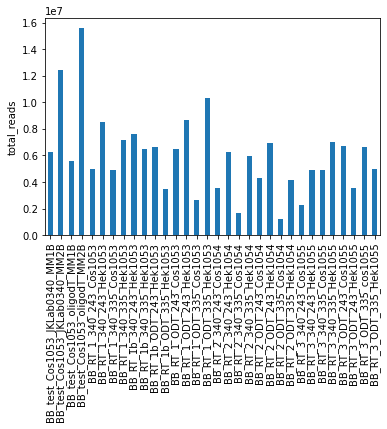

sa_reads


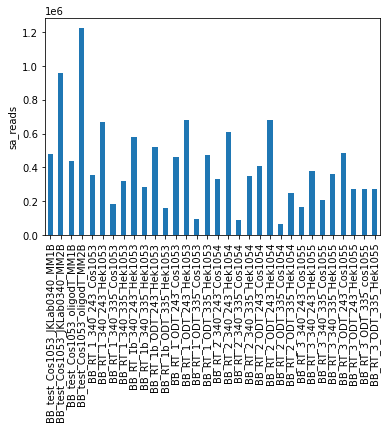

total_secondary


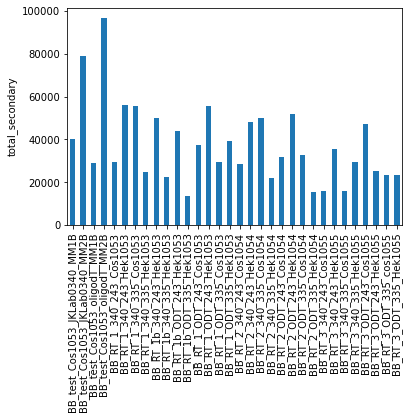

total_unmapped


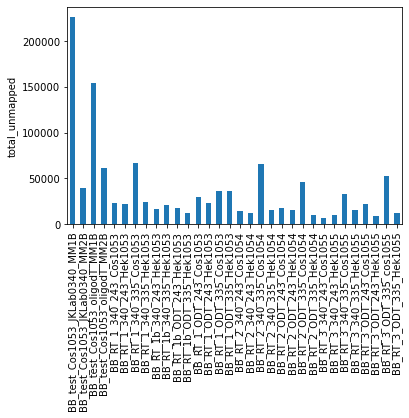

total_bad_starts


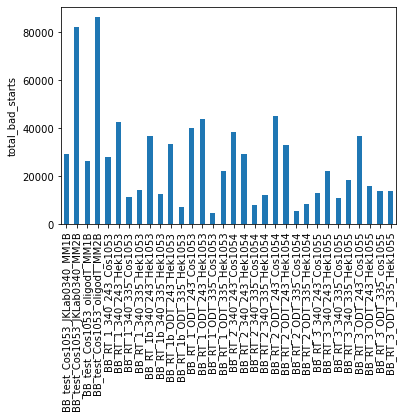

total_bad_ends


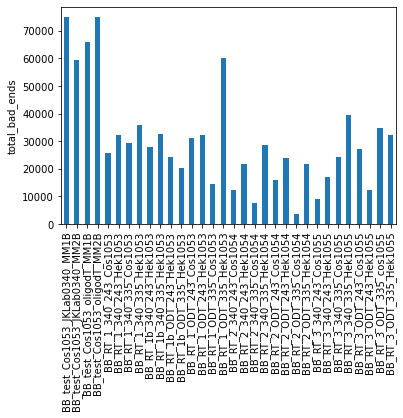

total_soft_clipped


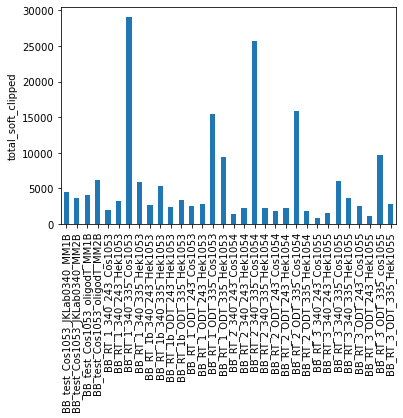

Percentages

sa_reads


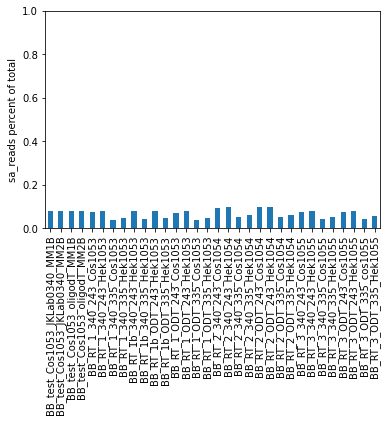

total_secondary


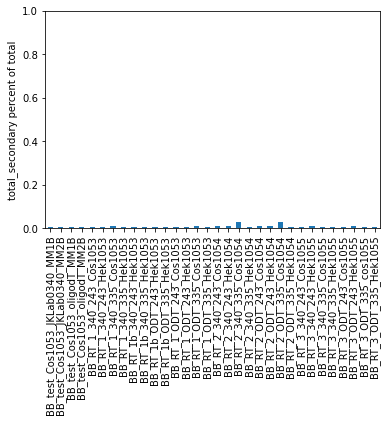

total_unmapped


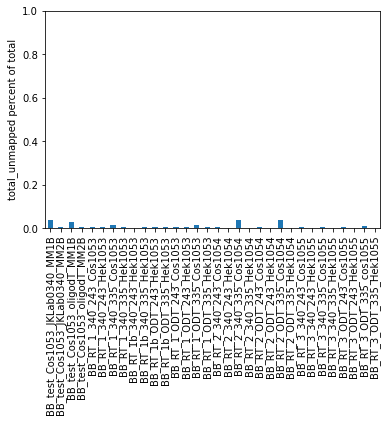

total_bad_starts


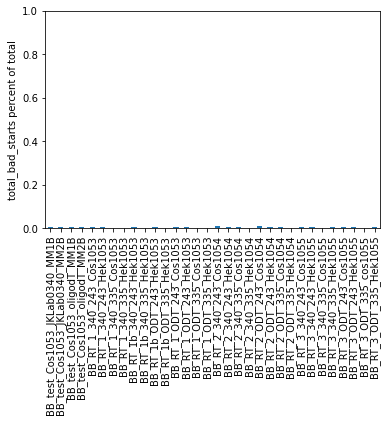

total_bad_ends


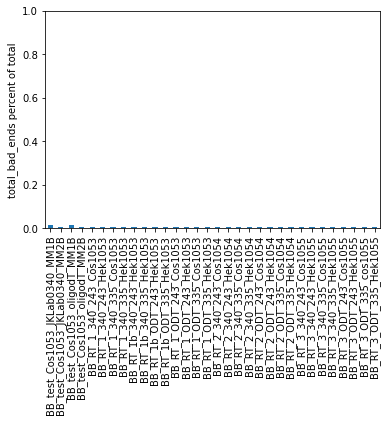

total_soft_clipped


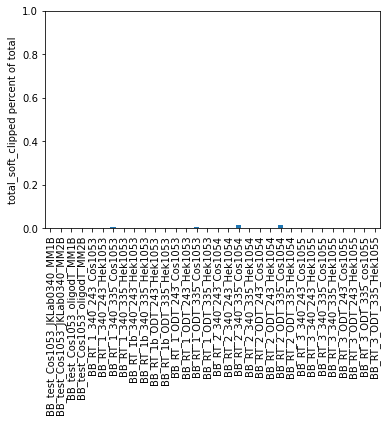

In [48]:
reads_df = sp.plot_iso_stats( iso_df_stats_all )

In [49]:
len( bam )

32

In [50]:
iso_df_stats_all.shape

(7244, 241)

In [51]:
total_cols = [ 'total_read_count', 'total_num_bcs', 'total_sum_sa_reads', 'total_num_vars', 'total_passfilt' ]

for col in total_cols:
    
    iso_df_stats_all[ col ] = iso_df_stats_all[ [ lcol for lcol in iso_df_stats_all if col + '_' in lcol ] ].sum( axis = 1 )

In [52]:
iso_df_stats_all.query( 'total_passfilt > 0' ).shape

(211, 246)

In [53]:
iso_df_stats_all.query( 'total_passfilt >= 16' ).shape

(14, 246)

In [54]:
( iso_df_stats_all.query( 'total_passfilt == 0' ).total_read_count.sum() / iso_df_stats_all.total_read_count.sum() )*100

2.5107582578531846

In [55]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_read_count.sum() / iso_df_stats_all.total_read_count.sum() )*100

97.19472535032455

In [56]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_sum_sa_reads.sum() / iso_df_stats_all.total_sum_sa_reads.sum() )*100

98.64717463030286

In [57]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_sum_sa_reads.sum() / iso_df_stats_all.query( 'total_passfilt >= 16' ).total_read_count.sum() )*100

6.884640469851816

In [58]:
( iso_df_stats_all.query( 'total_passfilt == 0' ).total_num_bcs.sum() / iso_df_stats_all.total_num_bcs.sum() )*100

2.4229879860787333

In [59]:
( iso_df_stats_all.query( 'total_passfilt >= 16' ).total_num_bcs.sum() / iso_df_stats_all.total_num_bcs.sum() )*100

96.86550153765006

In [60]:
iso_df_stats_all.query( 'total_passfilt >= 24' ).isoform.tolist()

[((1284, 1350),),
 ((1267, 1350),),
 ((1269, 1359),),
 ((1268, 1350),),
 ((1267, 1359),),
 ((1268, 1359),),
 ((1284, 1359),),
 (),
 ((1269, 1350),),
 ((1267, 1347),)]

In [65]:
iso_df_stats_all.query( 'total_passfilt >= 24' ).index.tolist()

[217, 1347, 2297, 2343, 2615, 3689, 4295, 4729, 5505, 5899]

In [69]:
iso_df_stats_use = iso_df_stats_all.query( 'total_passfilt > 0' ).copy()

In [70]:
iso_df_stats_use.loc[ ( iso_df_stats_use.isoform != ((1267, 1350),) ) & ( iso_df_stats_use.isoform != ((1267, 1359),) ) & ( iso_df_stats_use.isoform != () ) ].total_read_count.sum() / iso_df_stats_use.total_read_count.sum() 

0.008570681206857894

In [73]:
iso_df_stats_use = iso_df_stats_use.sort_values( by = 'total_read_count', ascending = False )

In [77]:
iso_df_stats_use

,isonum,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,...,total_read_count_JKP1055,total_num_bcs_JKP1055,total_num_vars_JKP1055,total_sum_sa_reads_JKP1055,total_passfilt_JKP1055,total_read_count,total_num_bcs,total_sum_sa_reads,total_num_vars,total_passfilt
4729,iso4729,(),1143438,2304126,1061553,3107707,1305008,1854048,3692206,5053752,...,17951136,165245.0,7689.0,619941.0,8,72128238,457498.0,2493725.0,25395.0,32
2615,iso2615,"((1267, 1359),)",2400983,5054368,2190619,6181763,1852419,3409654,499731,1003786,...,11336707,344050.0,8285.0,910206.0,8,59916978,798976.0,5409461.0,26638.0,32
1347,iso1347,"((1267, 1350),)",2202891,4607599,1962864,5733670,1642916,3029470,457547,943895,...,10520565,330426.0,8268.0,838041.0,8,54273041,766302.0,4903302.0,26497.0,32
4295,iso4295,"((1284, 1359),)",17771,39557,17553,45027,14635,17525,5468,6487,...,91562,4957.0,1925.0,7382.0,8,418128,14001.0,37196.0,6431.0,29
217,iso0217,"((1284, 1350),)",12129,23756,11547,30258,6932,10877,2801,4098,...,58755,3216.0,1531.0,4356.0,8,257596,9328.0,20616.0,5094.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3783,iso3783,"((1152, 1225), (1269, 1359))",0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0,7,2.0,7.0,2.0,1
2351,iso2351,"((1212, 1223), (1262, 1350))",0,0,0,0,0,0,0,0,...,6,1.0,1.0,3.0,1,6,1.0,3.0,1.0,1
5560,iso5560,"((1248, 1347),)",0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0,6,1.0,4.0,1.0,1
515,iso0515,"((1161, 1226), (1294, 1359))",0,0,0,0,0,0,0,0,...,1,0.0,0.0,0.0,0,5,1.0,3.0,1.0,1


In [79]:
100*( iso_df_stats_use.iloc[ 3:23 ].total_read_count.sum() / iso_df_stats_use.iloc[ 3: ].total_read_count.sum() )

77.16906969048458

In [61]:
isogrp_df.loc[ isogrp_df.isoform == ((1235, 1359),) ]

,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,BB_RT_1b_340_243_Hek1053_read_count,...,BB_RT_2_ODT_335_Cos1054_read_count,BB_RT_2_ODT_335_Hek1054_read_count,BB_RT_3_340_243_Cos1055_read_count,BB_RT_3_340_243_Hek1055_read_count,BB_RT_3_340_335_Cos1055_read_count,BB_RT_3_340_335_Hek1055_read_count,BB_RT_3_ODT_243_Cos1055_read_count,BB_RT_3_ODT_243_Hek1055_read_count,BB_RT_3_ODT_335_cos1055_read_count,BB_RT_3_ODT_335_Hek1055_read_count
isonum,,,,,,,,,,,,,,,,,,,,,
iso4730,"((1235, 1359),)",0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
iso_df_stats_all.loc[ iso_df_stats_all.isoform == ((1236, 1359),) ]

,isonum,isoform,BB_test_Cos1053_JKLab0340_MM1B_read_count,BB_test_Cos1053_JKLab0340_MM2B_read_count,BB_test_Cos1053_oligodT_MM1B_read_count,BB_test_Cos1053_oligodT_MM2B_read_count,BB_RT_1_340_243_Cos1053_read_count,BB_RT_1_340_243_Hek1053_read_count,BB_RT_1_340_335_Cos1053_read_count,BB_RT_1_340_335_Hek1053_read_count,...,total_read_count_JKP1055,total_num_bcs_JKP1055,total_num_vars_JKP1055,total_sum_sa_reads_JKP1055,total_passfilt_JKP1055,total_read_count,total_num_bcs,total_sum_sa_reads,total_num_vars,total_passfilt
54,iso0054,"((1236, 1359),)",2220,7515,3758,8960,2833,3111,391,358,...,13216,898.0,518.0,1122.0,8,68262,2904.0,6501.0,1893.0,19


In [63]:
iso_df_stats_all.to_csv( bdout + 'wt1_ex9_isoforms_2022-0915.txt',
                         sep = '\t',
                         index = False )

In [64]:
reads_df.to_csv( bdout + 'wt1_ex9_read_cnts_2022-0915.txt',
                         sep = '\t',
                         index = False )